In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
inspector=inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
columns_m = inspector.get_columns('Measurement')
for column in columns_m:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns_s = inspector.get_columns('Station')
for column in columns_s:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
dates = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
for d in dates:
  print(d)

2017-08-23


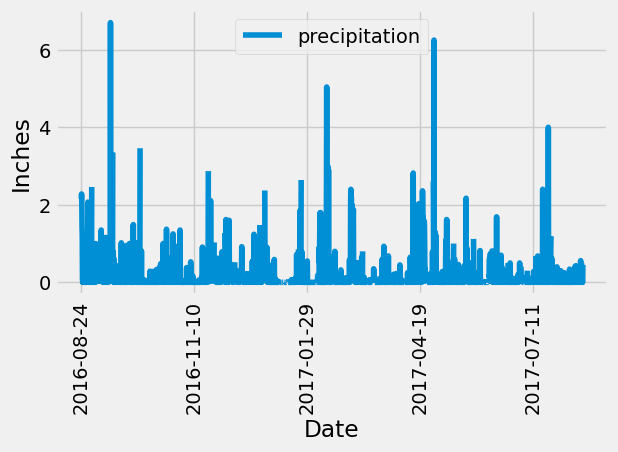

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
from dateutil.relativedelta import relativedelta
recent = dt.datetime.strptime(d, '%Y-%m-%d').date()
filter_date = recent - relativedelta(years=1)
filter_date

# Perform a query to retrieve the data and precipitation scores
last_12_months = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > filter_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(last_12_months, columns=['date', 'precipitation'])
df.set_index('date')

# Sort the dataframe by date
df = df.sort_values(by=['date'])


# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='date', y='precipitation', rot=90,ylabel="Inches", xlabel="Date")
plt.tight_layout()
plt.show()



In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
stations_count = session.query(Measurement.station).\
    group_by(Measurement.station).count()
stations_count

9

In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
query = sqlalchemy.select([Measurement.station, sqlalchemy.func.count(Measurement.station)]).group_by(Measurement.station).order_by(sqlalchemy.func.count(Measurement.station).desc())
result = engine.execute(query).fetchall()
for i in result:
    print("\n", i)


 ('USC00519281', 2772)

 ('USC00519397', 2724)

 ('USC00513117', 2709)

 ('USC00519523', 2669)

 ('USC00516128', 2612)

 ('USC00514830', 2202)

 ('USC00511918', 1979)

 ('USC00517948', 1372)

 ('USC00518838', 511)


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
result = engine.execute(query).first()
most_active_station = result[0]

most_active_station_data = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    order_by(Measurement.tobs).all()

df_most_active_station_data = pd.DataFrame(most_active_station_data, columns=['station', 'tobs'])
df_most_active_station_data.describe()

,tobs
count,2772.000000
mean,71.663781
std,4.357642
min,54.000000
25%,69.000000
50%,72.000000
75%,74.000000
max,85.000000


Text(0.5, 0, 'Temperature')

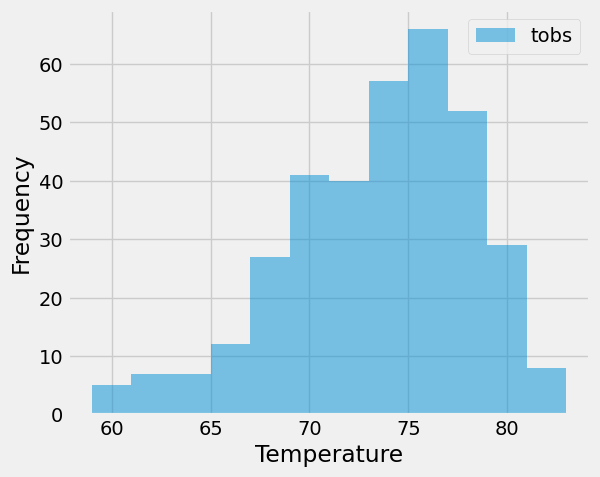

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_12_months = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date > filter_date).\
    filter(Measurement.station == most_active_station).all()

df = pd.DataFrame(most_active_station_12_months, columns=['date', 'tobs'])
ax = df.plot.hist(bins=12, alpha=0.5, figsize = (6,5))
ax.set_xlabel("Temperature")


# Close session

In [19]:
# Close Session
session.close()